# Time-series classification of binary heartbeat using DL 

https://www.timeseriesclassification.com/description.php?Dataset=BinaryHeartbeat

We adopt the CNN model to perform the binary classification. 

In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
from time import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix 
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# The data can be downloaded from https://www.timeseriesclassification.com/description.php?Dataset=BinaryHeartbeat
train = arff.loadarff('BinaryHeartbeat_TRAIN.arff')
test = arff.loadarff('BinaryHeartbeat_TEST.arff')

In [3]:
train = pd.DataFrame(train[0])
test = pd.DataFrame(test[0])

In [4]:
train_X = train.iloc[:,:-1].values
test_X = test.iloc[:,:-1].values

In [5]:
le = LabelEncoder()
train_y =le.fit_transform(train.iloc[:,-1])
test_y =le.transform(test.iloc[:,-1])

Number of classes

In [6]:
output_steps = len(np.unique(train_y))

The index is randomized for validation the trained model.

In [7]:
idx = np.random.permutation(len(train_X))

train_X = train_X[idx]
train_y = train_y[idx]

In [8]:
#Number of epochs
epochs = 50

# batch size
batch_size = 16

# verbose
verbose = 0

# CNN model

In [9]:
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))

In [10]:
input_shape = (train_X.shape[1], 1)

In [11]:
model = Sequential()
model.add(Conv1D(filters=1024, kernel_size=8, padding="same", input_shape=input_shape))
model.add(MaxPooling1D(pool_size=8))
model.add(Flatten())
model.add(Dense(100, activation='tanh'))
model.add(Dropout(0.05))
model.add(Dense(output_steps, activation="softmax"))
model.compile(loss=SparseCategoricalCrossentropy(), 
            optimizer=Adam(learning_rate=0.0005), 
            metrics=[SparseCategoricalAccuracy()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 18530, 1024)       9216      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2316, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2371584)           0         
_________________________________________________________________
dense (Dense)                (None, 100)               237158500 
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 237,167,918
Trainable params: 237,167,918
Non-trainable params: 0
__________________________________________

In [12]:
early_stopping_monitor = EarlyStopping(patience=15)
start = time()
history = model.fit(train_X, train_y, epochs=epochs, verbose=verbose, 
                    batch_size=batch_size, validation_split=0.2, 
                    callbacks = [early_stopping_monitor], shuffle=False)
end = time()
print("Training time: ",end - start)

Training time:  311.91773867607117


Text(0, 0.5, 'Loss')

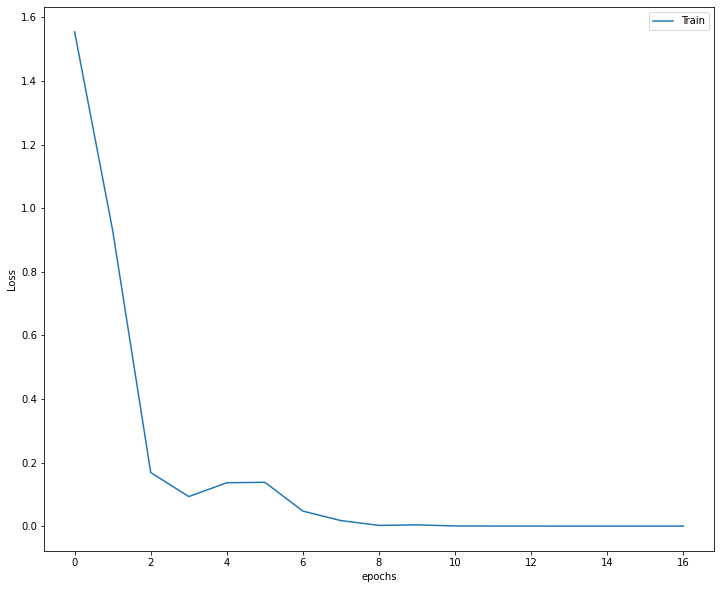

In [13]:
# Plot for train losses
plt.figure(figsize=(12,10))
plt.plot(history.history['loss'], label='Train', )
plt.legend()
plt.rc('font', size=10)
plt.xlabel("epochs")
plt.ylabel('Loss')

In [14]:
def classification_metrics(truedata, pred):
    print("Metrics")
    print("=======================")
    tn, fp, fn, tp = confusion_matrix(truedata, pred).ravel()
    print("True positive: ", tp)
    print("True negative: ", tn)
    print("False positive: ", fp)
    print("False negative: ", fn)
    print()
    print("Accuracy: ", round(accuracy_score(truedata, pred),3))
    print("F1 score: ", round(f1_score(truedata, pred),3))
    print("Precision: ", round(precision_score(truedata, pred),3))
    print("Recall: ", round(recall_score(truedata, pred),3))

Performance

In [15]:
size = test_y.shape[0]
pred = model.predict(test_X)
testpred = np.array([1-round(pred[x][0]) for x in range(0,size)])
classification_metrics(test_y, testpred)

Metrics
True positive:  9
True negative:  130
False positive:  20
False negative:  46

Accuracy:  0.678
F1 score:  0.214
Precision:  0.31
Recall:  0.164


In [16]:
fpr = {} 
tpr = {}
roc_auc = {}
fpr["CNN"], tpr["CNN"], thresholds = roc_curve(test_y, pred[:,1])
roc_auc["CNN"] = round(auc(fpr["CNN"], tpr["CNN"]),2)

# Plot of ROC

In [17]:
column = ["CNN"]

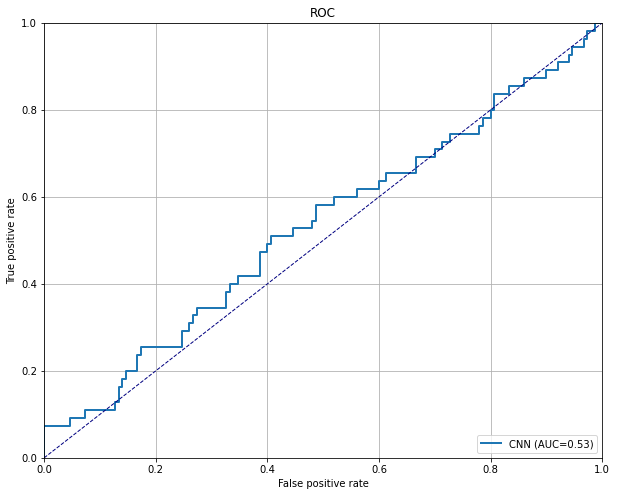

In [18]:
plt.figure(figsize=(10,8))
for col in column:
    plt.plot(fpr[col], tpr[col], lw=2, label="{} (AUC={})".format(col,roc_auc[col]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
plt.xlim([0,1])
plt.ylim([0,1])
plt.title("ROC")
plt.grid(True)
ax = plt.gca()
plt.legend(loc='lower right')

# Summary

In this approach, we do not need to extract features in advance. The CNN model directly train the model by using the data of time series. 
Compared to the performance using ML methods, the F1 score and AUC are lower using this approach. In addition, the training time is longer. It is noticed that the number of sample is relatively small. It is suggested that the sample size can be increased by using the synethetic data to improve the performance of this approach.